## Initialization

### pip

In [82]:
%pip install --user jupyter_contrib_nbextensions
!/vol/scratch/guy/miniconda/bin/python3.7 -m jupyter contrib nbextension install --user

Note: you may need to restart the kernel to use updated packages.
[I 22:13:21 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 22:13:21 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 22:13:22 InstallContribNbextensionsApp] Installing /specific/scratches/scratch/guy/miniconda/lib/python3.7/site-packages/jupyter_contrib_nbextensions/nbextensions/zenmode -> zenmode
[I 22:13:22 InstallContribNbextensionsApp] Making directory: /specific/a/home/cc/students/cs/dar/.local/share/jupyter/nbextensions/zenmode/
[I 22:13:22 InstallContribNbextensionsApp] Copying: /specific/scratches/scratch/guy/miniconda/lib/python3.7/site-packages/jupyter_contrib_nbextensions/nbextensions/zenmode/zenmode.yaml -> /specific/a/home/cc/students/cs/dar/.local/share/jupyter/nbextensions/zenmode/zenmode.yaml
[I 22:13:22 InstallContribNbextensionsApp] Copying: /specific/scratches/scratch/guy/miniconda/lib/python3.7/site-pack

In [83]:
!!/vol/scratch/guy/miniconda/bin/python3.7 -m jupyter nbextension enable toc2/main

['Enabling notebook extension toc2/main...',
 '      - Validating: \x1bOK\x1b']

In [6]:
%pip install torch==1.3.1+cu100 torchvision==0.4.2+cu100 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [7]:
%cd /vol/scratch/guy/torch-transformers-cache/
!git clone https://github.com/huggingface/transformers.git
%pip install ./transformers
%pip install -U nlp

/specific/scratches/scratch/guy/torch-transformers-cache
fatal: destination path 'transformers' already exists and is not an empty directory.
Processing ./transformers
  Created wheel for transformers: filename=transformers-3.0.2-py3-none-any.whl size=801243 sha256=632bcef30db79fe88ecc196bf93445cfffd14b1c656f188478eaee873a38bc4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mizzaam1/wheels/39/32/32/2acb69904d2cb31855aef2717e90dbf52ea3cd7ee61f887462
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 3.0.2
    Uninstalling transformers-3.0.2:
      Successfully uninstalled transformers-3.0.2
Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: nlp in /specific/scratches/scratch/guy/miniconda/lib/python3.7/site-packages (0.3.0)
Note: you may need to restart the kernel to use updated packages.


In [8]:
%cd /vol/scratch/guy/
!mkdir datasets
!mkdir torch-transformers-cache
## Not working!!!
!setenv TRANSFORMERS_CACHE /vol/scratch/guy/torch-transformers-cache
!setenv CUDA_VISIBLE_DEVICES 0

/specific/scratches/scratch/guy
mkdir: cannot create directory 'datasets': File exists
mkdir: cannot create directory 'torch-transformers-cache': File exists


In [2]:
%pip install matplotlib seaborn pandas tqdm

Note: you may need to restart the kernel to use updated packages.


In [56]:
%pip install ipywidgets
# %conda install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |################################| 10.5 MB 9.1 MB/s eta 0:00:01
     |################################| 510 kB 13.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### import

In [1]:
cache_dir = "/vol/scratch/guy/torch-transformers-cache/"
import torch
from tokenizers import Tokenizer
import transformers
from transformers import AutoModel, AutoTokenizer, pipeline
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk

%matplotlib inline
%cd /vol/scratch/guy/datasets

/specific/scratches/scratch/guy/datasets


## Phrase Tokenizer

### Load dataset

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf acl*.tar.gz

In [14]:
import glob
sentences = []
target = []
path = '/vol/scratch/guy/datasets/aclImdb/train/**/*.txt' 
files = glob.glob(path)
for name in tqdm(files):
    with open(name) as f:
        target+=[int('pos' in name)] # Classical quick & dirty
        sentences += [l for l in f]

100%|██████████| 75000/75000 [01:49<00:00, 687.41it/s] 


### "word-BPE" encoding

In [15]:
from collections import defaultdict

corpus = sentences
vocab = defaultdict(int)

for sentence in tqdm(corpus):
    for n in range(3):
        ngrams = (nltk.ngrams(sentence.lower().split(), n))
        for a in ngrams:
            vocab[a] += 1

100%|██████████| 75000/75000 [00:49<00:00, 1527.07it/s]


In [16]:
n_tokens = 85000
pad_idx = n_tokens
tokens = list(map(lambda x: " ".join(x[0]), sorted(vocab.items(), key = lambda x: x[1], reverse=True)[:n_tokens]))

In [17]:
class NgramTokenizer:
    def encode(self, sentence):
        sentence_ = sentence.split()
        id_list = []
        for word in sentence_:
            if word in tokens:
                id_list+=[tokens.index(word)]
            else:
                id_list+=[pad_idx]

        i = 0
        max_merges = 10
        have_merged_ids = True
        while i < max_merges and have_merged_ids:
            id_list, have_merged_ids = self._try_merge(id_list)
            i += 1
            
        return id_list
    def decode(self, id_list):
        return " ".join(map(self.id_to_token, id_list))
    
    def _try_merge(self, id_list):
        bigrams = list(nltk.ngrams(id_list, 2))
        t = 0
        new_id_list = []
        have_merged_ids = False
        while t <= len(bigrams):
            if t >= len(bigrams):
                new_id_list+= [id_list[t]]
            else:
                purported_token = (" ".join(map(self.id_to_token, bigrams[t])))
                if purported_token in tokens:
                    new_id_list += [tokens.index(purported_token)]
                    t += 1
                    have_merged_ids = True
                else:
                    new_id_list += [id_list[t]]
            t+=1 
        return new_id_list, have_merged_ids
    
    def id_to_token(self, i):
        if i < len(tokens):
            return tokens[i]
        else:
            return "<UNK>"
        

In [18]:
tokenizer = NgramTokenizer()

#### Play around with statistics

In [14]:
q = []
for i in tqdm(range(300)):
    q += [len((tokenizer.encode(corpus[i])))/len(corpus[i].split())]

100%|██████████| 300/300 [03:53<00:00,  1.24it/s]


0.7123880549081645


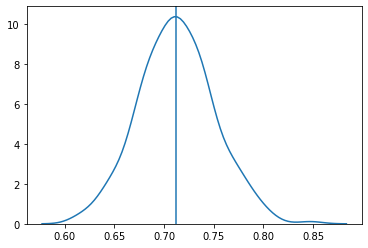

In [20]:
sns.kdeplot(q)
plt.axvline(np.mean(q))
print(np.mean(q))

#### Tokenize all sentences and save to file (deprecated)

In [56]:
!touch /vol/scratch/guy/datasets/sentences_encoded.txt

In [ ]:
f = open("/vol/scratch/guy/datasets/sentences_encoded.txt","a")
for s in tqdm(sentences[:20000]):
    f.writelines([str(tokenizer.encode(s))])
f.close()

  2%|▏         | 436/20000 [05:29<2:52:55,  1.89it/s]

In [10]:
f = open("/vol/scratch/guy/datasets/sentences_encoded.txt","r")
tokenized_sentences = []
for i, line in enumerate(tqdm(f)):
    
    arr = str.replace(str.replace(line,'[',''),']','')
    tokenized_sentences += [np.fromstring(arr, sep = ',',dtype = int)]
    
f.close()

0it [00:00, ?it/s]


TypeError: 'str' object cannot be interpreted as an integer

In [34]:
np.save("sentences_encoded.npy", tokenized_sentences)

/specific/scratches/scratch/guy/miniconda/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


#### Load from file (deprecated)

In [6]:
tokenized_sentences = list(np.load("sentences_encoded.npy", allow_pickle = True))

### Transformer

In [11]:
AutoModel.from_config('BertConfig')

ValueError: Unrecognized configuration class <class 'str'> for this kind of AutoModel: AutoModel.
Model type should be one of RetriBertConfig, T5Config, DistilBertConfig, AlbertConfig, CamembertConfig, XLMRobertaConfig, BartConfig, LongformerConfig, RobertaConfig, BertConfig, OpenAIGPTConfig, GPT2Config, MobileBertConfig, TransfoXLConfig, XLNetConfig, FlaubertConfig, XLMConfig, CTRLConfig, ElectraConfig, ReformerConfig.

In [ ]:
tokenizer.tokenized_sentences